In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer, Dropout
from keras.models import Model
from keras import backend as K
from keras import metrics
import pandas as pd
#import tensorflow as tf
import keras

In [3]:
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
#import pydot
#import graphviz
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import manifold

In [5]:
asthma_df=pd.read_csv("ukbb_asthma_sample_5k.csv",sep='\t')

/opt/wakari/anaconda/envs/default/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3,2931,2943) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# Select columns to filter on
cols = [col for col in asthma_df.columns if 'HES_p' not in col and 'PC' not in col]
asthma_df=asthma_df[cols].drop('Unnamed: 0',axis=1)

In [8]:
#select only 'QUANTITY' fields
asthma_df_quant=asthma_df.loc[:, asthma_df.columns.str.contains('QUANT|age|BMI')].fillna(0.0)
#select only fields with 10 or more unique values
for col in asthma_df_quant.columns:
    if len(asthma_df_quant[col].unique()) < 20 :
        asthma_df_quant.drop(col,inplace=True,axis=1)

        
#select only 'QUANTITY' and "CATEGORY" fields
asthma_df_quant_cat=asthma_df.loc[:, asthma_df.columns.str.contains('QUANT|age|BMI|CAT|sex')].fillna(0.0)
asthma_df_quant_cat=asthma_df_quant_cat.drop(columns=['f_22182_0_0_f_CAT_HLA_imputation_values_and_quality'])

In [17]:
#asthma_df_quant_cat['f_40019_0_p_D44_CAT_Neoplasm_of_uncertain_or_unknown_behaviour_of_endocrine_glands'].value_counts()

In [18]:
#asthma_df_quant_cat.loc[:,asthma_df_quant_cat.columns.str.contains('CAT')]

In [20]:
asthma_df_quant.head()

,age,BMI,f_20006_0_0_f_QUANT_Interpolated_Year_when_cancer_first_diagnosed,f_20008_0_0_f_QUANT_Interpolated_Year_when_non_cancer_illness_first_diagnosed,f_20010_0_0_f_QUANT_Interpolated_Year_when_operation_took_place,f_1269_0_0_f_QUANT_Exposure_to_tobacco_smoke_at_home,f_1279_0_0_f_QUANT_Exposure_to_tobacco_smoke_outside_home,f_1807_0_0_f_QUANT_Father_s_age_at_death,f_2867_0_0_f_QUANT_Age_started_smoking_in_former_smokers,f_2966_0_0_f_QUANT_Age_high_blood_pressure_diagnosed,...,specialRequest_QUANT_number_of_hospitalizing_copd_exacerbation_caseOnly_includes_SPIROMETRY_NI_HES_residualizedRelated,specialRequest_QUANT_number_of_hospitalizing_copd_exacerbation_caseOnly_smokersOnly_includes_SPIROMETRY_NI_HES_residualizedRelated,specialRequest_QUANT_numCigarettes_residualizedRelated,specialRequest_QUANT_age_started_smoking_residualizedRelated,specialRequest_QUANT_age_stopped_smoking_residualizedRelated,specialRequest_QUANT_pack_years_residualizedRelated,specialRequest_QUANT_appendicular_lean_mass_residualizedRelated,specialRequest_ageSquared_QUANT_age_squared,specialRequest_QUANT_years_observed_in_primary_HES,specialRequest_QUANT_OA_HES_based_age_of_onset
0,63,21.3476,2004.5,0.00,1980.5,0.0,0.0,60.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3969,0.134247,0.0
1,51,25.9862,0.0,2007.50,1965.5,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2601,0.002740,0.0
2,58,21.2239,0.0,2010.23,0.0,0.0,0.0,75.0,0.0,58.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3364,0.002740,0.0
3,69,27.0389,0.0,1970.88,0.0,0.0,0.0,59.0,0.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4761,0.002740,0.0
4,64,31.5993,0.0,1996.17,0.0,0.0,0.0,89.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.132985,4096,0.010959,0.0


In [73]:
#data=asthma_df_quant.transpose().values
asthma_df_quant_scaled=asthma_df_quant
scaler = preprocessing.MinMaxScaler(feature_range=(0.0, 1.0))
asthma_df_quant_scaled[asthma_df_quant_scaled.columns]=scaler.fit_transform(asthma_df_quant[asthma_df_quant.columns])

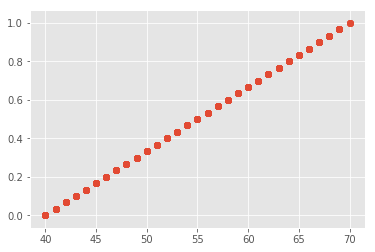

In [86]:
plt.scatter(asthma_df['age'].values,asthma_df_quant_scaled['age'].values)

In [89]:
data_minmax=asthma_df_quant_scaled.values

In [91]:
print data_minmax.shape

(5000, 638)


In [92]:
batch_size = 50
original_dim = data.shape[1]
#latent_dim = 2
latent_dim=12
#intermediate_dim = 500
epochs = 200
epsilon_std = 1.0
learning_rate=0.0005
momentum=0.9

In [93]:
def sampling(args):
    
    import tensorflow as tf
    epsilon_std=1.0
    
    z_mean, z_log_var = args
    #epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                             # stddev=epsilon_std)
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

def vae_loss(x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - K.exp(z_log_var_encoded), axis=-1)
        return K.mean(xent_loss + kl_loss)

In [94]:
#Encoder
x = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections, batch norm,
# and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the input tensor
# Use dropout to help with training and overfitting
# Use batch normalization for regularization

dropout_frac=0.1
dropout_mean=Dropout(dropout_frac, input_shape=(original_dim,))(x)
dropout_var=Dropout(dropout_frac, input_shape=(original_dim,))(x)

z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(dropout_mean)
z_mean_dense_batchnorm = keras.layers.BatchNormalization(momentum=momentum)(z_mean_dense_linear)
z_mean_encoded = keras.layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(dropout_var)
z_log_var_dense_batchnorm = keras.layers.BatchNormalization(momentum=momentum)(z_log_var_dense_linear)
z_log_var_encoded = keras.layers.Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

In [95]:
#Decoder
decoder = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
expression_reco = decoder(z)

In [96]:
np.random.seed(123)

In [97]:
adam = keras.optimizers.Adam(lr=learning_rate)

#vae_layer = CustomVariationalLayer()([x, expression_reconstruct])
#vae = Model(x, vae_layer)
vae = Model(x, expression_reco)
#RMS prop seems to be the most stable optimizer for this config
vae.compile(optimizer="rmsprop", loss=vae_loss)
#vae.compile(optimizer=adam, loss=vae_loss)

print vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 638)          0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 638)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 638)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12)           7668        dropout_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (D

In [99]:
import time
start = time.clock()
data_split=0.2
data_train, data_test = train_test_split(data_minmax, test_size=data_split)
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph_AN_Variational', histogram_freq=0, write_graph=True, write_images=True)
earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')
callbacks_list = [tbCallBack,earlystop]

In [100]:
hist1=vae.fit(data_train,data_train,
        #shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=callbacks_list)

Train on 3200 samples, validate on 800 samples
Epoch 1/200
3200/3200 [==============================] - 1s 228us/step - loss: 433.3987 - val_loss: 412.9438
Epoch 2/200
3200/3200 [==============================] - 0s 126us/step - loss: 403.9192 - val_loss: 384.5409
Epoch 3/200
3200/3200 [==============================] - 0s 131us/step - loss: 381.5680 - val_loss: 367.1635
Epoch 4/200
3200/3200 [==============================] - 0s 134us/step - loss: 364.4987 - val_loss: 355.5708
Epoch 5/200
3200/3200 [==============================] - 0s 135us/step - loss: 353.9066 - val_loss: 346.2848
Epoch 6/200
3200/3200 [==============================] - 0s 141us/step - loss: 347.1063 - val_loss: 343.9981
Epoch 7/200
3200/3200 [==============================] - 1s 215us/step - loss: 343.8761 - val_loss: 340.7625
Epoch 8/200
3200/3200 [==============================] - 1s 187us/step - loss: 341.6021 - val_loss: 340.1570
Epoch 9/200
3200/3200 [==============================] - 0s 130us/step - loss: 34

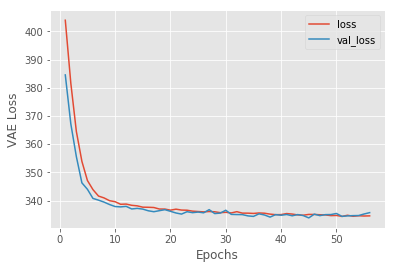

In [103]:
#Visualize training performance
history_df = pd.DataFrame(hist1.history)
ax = history_df[1:].plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
#plt.yscale('log')

In [104]:
trained = time.clock()
print "Time to train: ",trained-start

Time to train:  106.76


In [105]:
# encoder, from inputs to latent space
encoder = Model(x, z_mean_encoded)
#encoder = Model(x, z)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
decoded_latent=decoder(decoder_input)
generator=Model(decoder_input,decoded_latent)

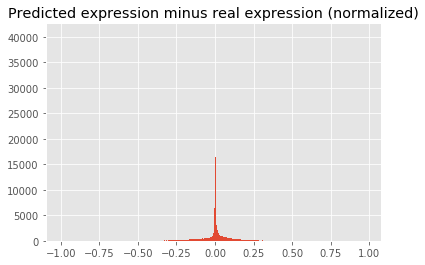

0.0002713506199267008 0.11542296422686471


In [106]:
#data_predict=vae.predict(data_test,batch_size=batch_size)
data_predict=vae.predict_on_batch(data_test)
diffs=np.subtract(data_predict,data_test).flatten()


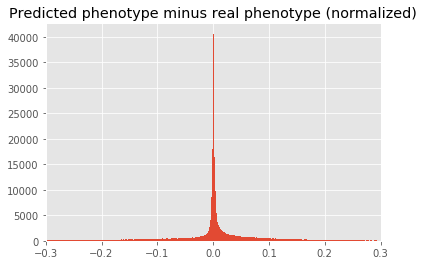

0.0002713506199267008 0.11542296422686471


In [113]:
plt.hist(diffs, bins='auto')  # plt.hist passes it's arguments to np.histogram

plt.title("Predicted phenotype minus real phenotype (normalized)")
plt.xlim(-0.3,0.3)
plt.show()
print np.mean(diffs),np.std(diffs)

In [115]:
encoded_predict=encoder.predict(data_test)


In [140]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=50,
                     learning_rate=10, n_iter=1000)
#tsne = manifold.TSNE(n_components=2, init='pca')

tsne_out = tsne.fit_transform(encoded_predict)



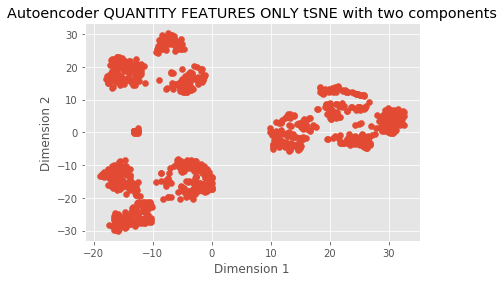

In [141]:
plt.scatter(tsne_out[:,0],tsne_out[:,1])

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Autoencoder QUANTITY FEATURES ONLY tSNE with two components')
plt.show()


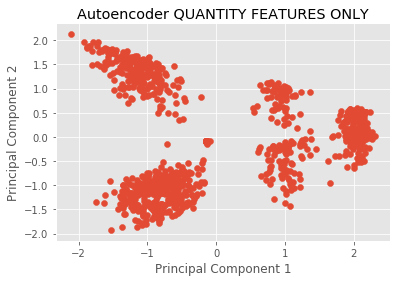

In [122]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca_out=pca.fit_transform(encoded_predict)

plt.scatter(pca_out[:,0],pca_out[:,1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Autoencoder QUANTITY FEATURES ONLY')
plt.show()